## CMPS-3240-01: Introduction to Machine Learning
## Homework Assignment 3 for Alex Olteanu

### Setup

In [107]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# Common imports
import pandas as pd
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

### 1. Write fetch_kmnist_data(). You'll need to use urllib. Do NOT download and unzip the files yourself. You can reuse and modify the mnist_reader.load_mnist() function to load data. There are four files to download in that address.

In [108]:
import urllib.request

def fetch_kmnist_data():
    # Downloading KMNIST images
    urllib.request.urlretrieve("http://codh.rois.ac.jp/kmnist/dataset/kmnist/kmnist-train-imgs.npz", "kmnist-train-imgs.npz")
    urllib.request.urlretrieve("http://codh.rois.ac.jp/kmnist/dataset/kmnist/kmnist-train-labels.npz", "kmnist-train-labels.npz")
    urllib.request.urlretrieve("http://codh.rois.ac.jp/kmnist/dataset/kmnist/kmnist-test-imgs.npz", "kmnist-test-imgs.npz")
    urllib.request.urlretrieve("http://codh.rois.ac.jp/kmnist/dataset/kmnist/kmnist-test-labels.npz", "kmnist-test-labels.npz")

    # Load KMNIST images into a NumPy Array
    train_imgs = np.load("kmnist-train-imgs.npz")['arr_0']
    train_labels = np.load("kmnist-train-labels.npz")['arr_0']
    test_imgs = np.load("kmnist-test-imgs.npz")['arr_0']
    test_labels = np.load("kmnist-test-labels.npz")['arr_0']

    return train_imgs, train_labels, test_imgs, test_labels

# Store KMNIST data in appropriate variables
x_train, y_train, x_test, y_test = fetch_kmnist_data()

### 2. Plot the first 100 images with 10 images per row similar to what we did with MNIST.

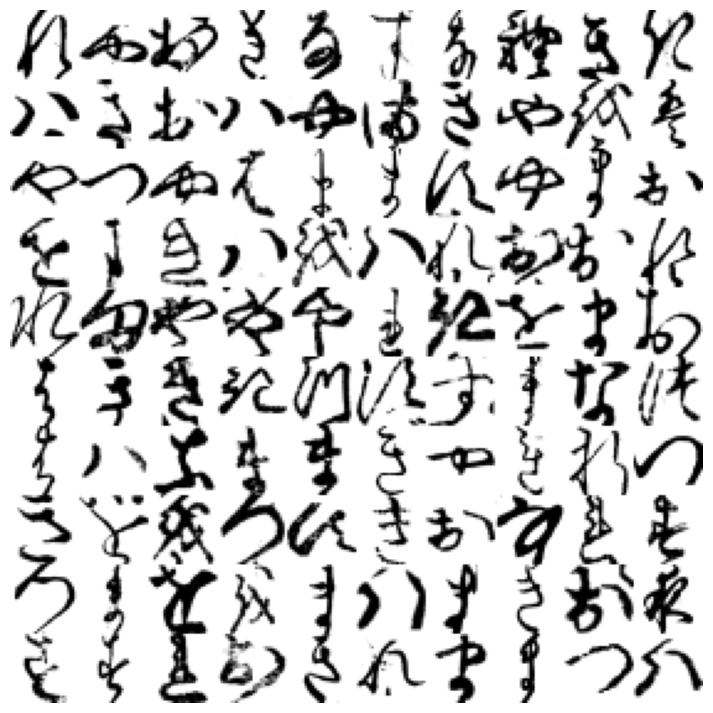

In [109]:
def plot_digits(instances, images_per_row=10):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    # This is equivalent to n_rows = ceil(len(instances) / images_per_row):
    n_rows = (len(instances) - 1) // images_per_row + 1

    # Append empty images to fill the end of the grid, if needed:
    n_empty = n_rows * images_per_row - len(instances)
    padded_instances = np.concatenate([instances, np.zeros((n_empty, size, size))], axis=0)

    # Reshape the array so it's organized as a grid containing 28×28 images:
    image_grid = padded_instances.reshape((n_rows, images_per_row, size, size))

    # Combine axes 0 and 2 (vertical image grid axis, and vertical image axis),
    # and axes 1 and 3 (horizontal axes). We first need to move the axes that we
    # want to combine next to each other, using transpose(), and only then we
    # can reshape:
    big_image = image_grid.transpose(0, 2, 1, 3).reshape(n_rows * size, images_per_row * size)

    # Now that we have a big image, we just need to show it:
    plt.imshow(big_image, cmap = mpl.cm.binary)
    plt.axis("off")

# Plot the first 100 images of the KMNIST dataset
plt.figure(figsize=(9,9))
example_images = x_train[:100]
plot_digits(example_images, images_per_row=10)
plt.show()

### 3.

In [110]:
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score

# Create a subset of each variable containing the first 1000 samples
x_train_sub = x_train[:1000]
y_train_sub = y_train[:1000]
x_test_sub = x_test[:1000]
y_test_sub = y_test[:1000]

# Flatten the data
x_train_sub_reshaped = x_train_sub.reshape(-1, 28*28)
x_test_sub_reshaped = x_test_sub.reshape(-1, 28*28)

# Initialize SVC
clf = SVC(gamma="auto", kernel="linear")

# Conduct 4-fold cross validation for various metrics
cv_scores_accuracy = cross_val_score(clf, x_train_sub_reshaped, y_train_sub, cv=4)
cv_scores_precision = cross_val_score(clf, x_train_sub_reshaped, y_train_sub, cv=4, scoring='precision_macro')
cv_scores_recall = cross_val_score(clf, x_train_sub_reshaped, y_train_sub, cv=4, scoring='recall_macro')
cv_scores_f1 = cross_val_score(clf, x_train_sub_reshaped, y_train_sub, cv=4, scoring='f1_macro')

print("4-fold CV Accuracy:", cv_scores_accuracy)
print("Mean 4-fold CV Accuracy:", cv_scores_accuracy.mean(), "\n")

print("4-fold CV Precision:", cv_scores_precision)
print("Mean 4-fold CV Precision:", cv_scores_precision.mean(), "\n")

print("4-fold CV Recall:", cv_scores_recall)
print("Mean 4-fold CV Recall:", cv_scores_recall.mean(), "\n")

print("4-fold CV F1-Score:", cv_scores_f1)
print("Mean 4-fold CV F1-Score:", cv_scores_f1.mean(), "\n")

# Fit the model
clf.fit(x_train_sub_reshaped, y_train_sub)

# Evaluate the model
test_score = clf.score(x_test_sub_reshaped, y_test_sub)
print("Test score:", test_score)

4-fold CV Accuracy: [0.716 0.74  0.74  0.784]
Mean 4-fold CV Accuracy: 0.7449999999999999 

4-fold CV Precision: [0.72894223 0.75591543 0.75287069 0.79068956]
Mean 4-fold CV Precision: 0.7571044769145898 

4-fold CV Recall: [0.7224052  0.74419743 0.73894511 0.78319586]
Mean 4-fold CV Recall: 0.7471859004522048 

4-fold CV F1-Score: [0.72146194 0.7466492  0.74250799 0.78494499]
Mean 4-fold CV F1-Score: 0.748891029652546 

Test score: 0.623


### 4.

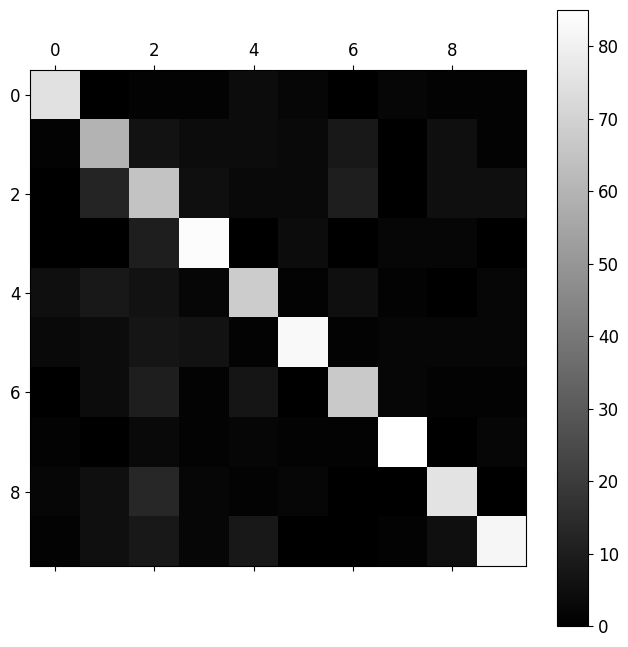

In [111]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix

# Using cross-validation to make predictions on the subset of training data
y_train_pred = cross_val_predict(clf, x_train_sub_reshaped, y_train_sub, cv=4)

# Generating the confusion matrix for true versus predicted labels
conf_mx = confusion_matrix(y_train_sub, y_train_pred)

# Since sklearn 0.22, you can use sklearn.metrics.plot_confusion_matrix()
def plot_confusion_matrix(matrix):
    """If you prefer color and a colorbar"""
    fig = plt.figure(figsize=(8,8))
    ax = fig.add_subplot(111)
    cax = ax.matshow(matrix, cmap=plt.cm.gray)
    fig.colorbar(cax)

# Plot the confusion matrix
plot_confusion_matrix(conf_mx)
plt.show()

### 5.

In [112]:
from sklearn.model_selection import GridSearchCV

gamma_values = [1E-5, 1E-4, 1E-3, 1E-2, 1E-1, 1E0, 1E1, 1E2, 1E3]

clf = SVC(kernel="linear")

# Setting up the grid search
grid_search = GridSearchCV(clf, param_grid={'gamma': gamma_values}, cv=4, scoring='accuracy', return_train_score=True)
grid_search.fit(x_train_sub_reshaped, y_train_sub)

GridSearchCV(cv=4, estimator=SVC(kernel='linear'),
             param_grid={'gamma': [1e-05, 0.0001, 0.001, 0.01, 0.1, 1.0, 10.0,
                                   100.0, 1000.0]},
             return_train_score=True, scoring='accuracy')

In [113]:
# Retrieve the best parameters
grid_search.best_params_

{'gamma': 1e-05}

In [114]:
# Retrieve the best estimators
grid_search.best_estimator_

SVC(gamma=1e-05, kernel='linear')

In [115]:
# Extract cross-validation results
cv_results = grid_search.cv_results_
for mean_score, gamma in zip(cv_results["mean_test_score"], gamma_values):
    print(f"Mean CV accuracy for gamma {gamma}: {mean_score}")

Mean CV accuracy for gamma 1e-05: 0.7449999999999999
Mean CV accuracy for gamma 0.0001: 0.7449999999999999
Mean CV accuracy for gamma 0.001: 0.7449999999999999
Mean CV accuracy for gamma 0.01: 0.7449999999999999
Mean CV accuracy for gamma 0.1: 0.7449999999999999
Mean CV accuracy for gamma 1.0: 0.7449999999999999
Mean CV accuracy for gamma 10.0: 0.7449999999999999
Mean CV accuracy for gamma 100.0: 0.7449999999999999
Mean CV accuracy for gamma 1000.0: 0.7449999999999999


In [116]:
# Display cross-validation results as a dataframe
pd.DataFrame(grid_search.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_gamma,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,mean_train_score,std_train_score
0,0.108483,0.006196,0.047530,0.001932,0.00001,{'gamma': 1e-05},0.716,0.74,0.74,0.784,0.745,0.024556,1,1.0,1.0,1.0,1.0,1.0,0.0
1,0.148946,0.001580,0.052701,0.002249,0.0001,{'gamma': 0.0001},0.716,0.74,0.74,0.784,0.745,0.024556,1,1.0,1.0,1.0,1.0,1.0,0.0
2,0.159621,0.013892,0.050647,0.003970,0.001,{'gamma': 0.001},0.716,0.74,0.74,0.784,0.745,0.024556,1,1.0,1.0,1.0,1.0,1.0,0.0
3,0.105658,0.003304,0.047297,0.000914,0.01,{'gamma': 0.01},0.716,0.74,0.74,0.784,0.745,0.024556,1,1.0,1.0,1.0,1.0,1.0,0.0
4,0.111257,0.011263,0.046900,0.002701,0.1,{'gamma': 0.1},0.716,0.74,0.74,0.784,0.745,0.024556,1,1.0,1.0,1.0,1.0,1.0,0.0
5,0.109038,0.008137,0.044581,0.000796,1.0,{'gamma': 1.0},0.716,0.74,0.74,0.784,0.745,0.024556,1,1.0,1.0,1.0,1.0,1.0,0.0
6,0.104862,0.001588,0.045713,0.002004,10.0,{'gamma': 10.0},0.716,0.74,0.74,0.784,0.745,0.024556,1,1.0,1.0,1.0,1.0,1.0,0.0
7,0.103984,0.004448,0.044804,0.000801,100.0,{'gamma': 100.0},0.716,0.74,0.74,0.784,0.745,0.024556,1,1.0,1.0,1.0,1.0,1.0,0.0
8,0.105480,0.006341,0.045251,0.001637,1000.0,{'gamma': 1000.0},0.716,0.74,0.74,0.784,0.745,0.024556,1,1.0,1.0,1.0,1.0,1.0,0.0
